In [1]:
# Module: Data Science in Finance, Machine Learning in 30 minutes!
# Version 1.0
# Topic : Clustering and building models
# Example source: https://www.kaggle.com/wendykan/lending-club-loan-data
#####################################################################
# For support or questions, contact Sri Krishnamurthy at
# sri@quantuniversity.com
# Copyright 2016 QuantUniversity LLC.
#####################################################################

# Clustering and building models

This notebook deals with understanding the lending data obtained from https://www.kaggle.com/wendykan/lending-club-loan-data. We will cluster the data using K-Means clustering to see patterns in the dataset.

### Imports

In [2]:
# for numerical analysis and data processing
import numpy as np
import pandas as pd
import itertools

from IPython.display import Image

# for Machine learning algorithms
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cdist

# for vizualizations
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

### Dataset

The data set is the lending data for lendingclub from August 2011 to December 2011 for some borrowers. The feature descriptions for the data are also provided. Not all the features are required for making predictions, some features are redundant in the original data file. The provided data file is already cleaned and only relevant features are provided. There are two types of features, numerical and categorical.

Reading the input data from csv file.

In [3]:
df = pd.read_csv("../data/LendingClubLoan.csv", low_memory=False)
del df['issue_d'] # removing issue date as it wont affect the prediction (redundant feature)
df_description = pd.read_excel('../data/LCDataDictionary.xlsx').dropna()

### Preparing categorical features

Categorical data is best processed by algorithms when converted to numerical format.The most common way is by mapping each category to an integers. Ex. \[A, B, C\] can be mapped to \[0, 1, 2\]. Another way is one-hot encoding which we will look into while building the models.

In [4]:
numeric_columns = df.select_dtypes(include=['float64','int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

In [5]:
for col in categorical_columns:
    df[col] = df[col].astype('category')

In [6]:
p_categories = df['purpose'].cat.categories.tolist()
s_categories = df['addr_state'].cat.categories.tolist()
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.cat.codes)

Storing interest rate statistics

In [7]:
min_rate= df['int_rate'].min()
max_rate= df['int_rate'].max()
print(min_rate, max_rate, max_rate- min_rate)

5.42 24.11 18.689999999999998


## Clustering - k-Means Clustering

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. According to this algorithm, a simple cluster:  
1. has a "cluster center" which is the arithmetic mean of all the points belonging to the cluster
2. has each point closer to its own cluster center than to other cluster centers

One of the most important parameters that has to be decided by the user is the value of k, the number of cluster. K random centroids are selected and the centroids are moved with each iteration of the algorithm until all points are assigned a cluster.

To select the value of K, one of the widely used method is called the Elbow Curve method. Logically, K-Means attempts to minimize distortion defined by the the sum of the squared distances between each observation and its closest centroid. This is called the cost function or distortion. We plot the values of dstortion against K and select where the plot forms an 'elbow joint' i.e. the point after which there is a gradual decrease in the distortion.

In [8]:
# this cell takes a few minutes to execute
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df[0:9999])
    kmeanModel.fit(df[0:9999])
    distortions.append(sum(np.min(cdist(df[0:9999], kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df[0:9999].shape[0])

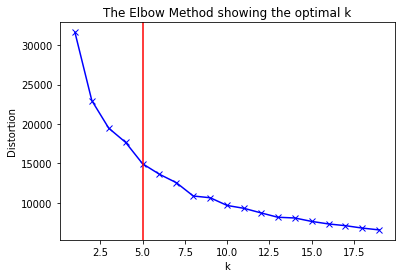

In [9]:
plt.plot(K, distortions, 'bx-')
plt.axvline(5, color='r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The distortion values will eventually reach 0 when the value of K is equal to the number of samples in the dataset, which is same as having one cluster for each point and is undesireable. In this experiment, the distortion changes by 15000 in the first 5 K values and then by 5000 in the next 15 K values. So we select K = 5 as the elbow point.

In [10]:
num_clusters = 5
num_samples = 9999

In [11]:
kmeans = KMeans(n_clusters=num_clusters, algorithm='elkan')
kmeans.fit(df[0:num_samples])

unique, counts = np.unique(kmeans.labels_, return_counts=True)
cluster_indices = np.asarray((unique, counts)).T[:,1].argsort()[-3:][::-1] # change -3 to -5 for all clusters

print('Samples per cluster:')
print (np.asarray((unique, counts)).T)

Samples per cluster:
[[   0 5210]
 [   1 1054]
 [   2  108]
 [   3    1]
 [   4 3626]]


Add the cluster label to the dataframe.

In [12]:
df_cluster = df.join(pd.DataFrame({'cluster': kmeans.labels_}), lsuffix='_caller', rsuffix='_other')

In [13]:
clusters = []
for i in cluster_indices:
    clusters.append(df_cluster[df_cluster['cluster']==i].loc[:, df.columns != 'cluster'])

### t-SNE

It is easy to vizualize data that has 2 or even 3 dimensions. It gets tricker to do so once we move over 3 dimensions. [t-SNE (t-Distributed Stochastic Neighbor Embedding)](https://lvdmaaten.github.io/tsne/) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. Here, we will try to represent our 16 dimensional data (16 feature) in 3 dimensions.

For a t-SNE plot, the relative distances between clusters or the relative distances within points of a single cluster do not signify anthing. It is just a way of visually representing the separation of clusters.

In [14]:
dimensions = 3
# t-SNE parmeters
iterations = 5000
perplexity = 40
# vizualisation is computationally intensive, so we'll stick to 500 samples
num_samples = 500

In [15]:
# this cell takes a few minutes to execute
tsne = TSNE(n_components=dimensions, random_state=0, perplexity=perplexity, n_iter =iterations)
embeddings = tsne.fit(df[0:num_samples])
# X_2d.embedding_

The new 3 dimensions as assigned by t-SNE

In [16]:
embeddings.embedding_[0:5]

array([[ 288.7012   ,   -7.7664275,   -8.215757 ],
       [ 246.7552   ,  -62.43229  ,  -71.17717  ],
       [ 257.74905  ,  -40.62806  ,   52.882473 ],
       [  20.292011 , -112.72798  ,  120.49461  ],
       [-193.28879  ,  -90.44925  ,   19.583723 ]], dtype=float32)

Plotting in 3d

c:\users\atharva jakkanwar\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


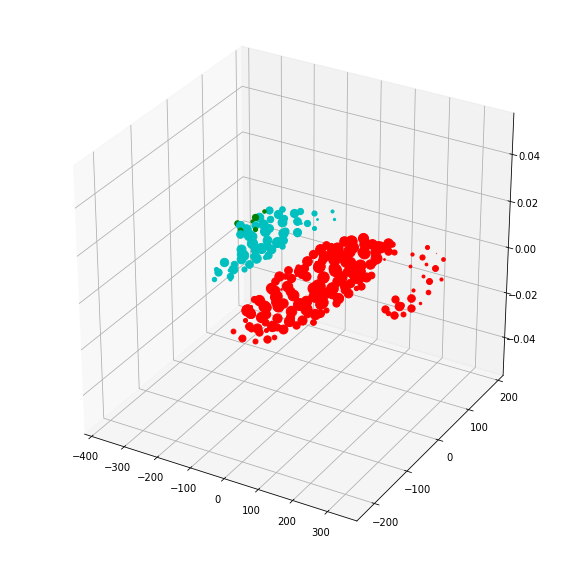

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b','black', 'c','k']
for i, val in zip(range(len(embeddings.embedding_)),kmeans.labels_):
    plt.scatter(embeddings.embedding_[i,0], embeddings.embedding_[i,1], embeddings.embedding_[i,2], c=colors[val])
plt.show()

2d top view of the same 3d plot

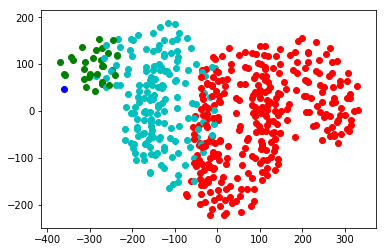

In [18]:
for i, val in zip(range(len(embeddings.embedding_)),kmeans.labels_):
    plt.scatter(embeddings.embedding_[i,0], embeddings.embedding_[i,1],c=colors[val])

In [19]:
from scipy.stats import mode

def print_mode(cluster, display = True):
    df_mode = mode(cluster)
    if display == True:
        print("%20s | %8s | %9s | %s" % ('Column', 'Mode', 'Mode Count', 'Mean'))
#         print(type(cluster.mean()))
        print("------------------------------------------------------------------")
        for c1, c2, c3, c4 in zip(df_cluster.dtypes.index, df_mode.mode[0], df_mode.count[0], cluster.mean().tolist()):  
            print ("%20s | %8s | %9s | %s" % (c1, c2, c3, c4))
        print()
    return df_cluster.dtypes.index, df_mode.mode[0], df_mode.count[0]

def display_cluster_mode_feature(cluster):
    # showing from 8 onwards as previous all features have similar distribution across clusters 
    sns.barplot(y = cluster[0][cluster[2].argsort()[::-1]][8:], x = np.sort(cluster[2])[::-1][8:], palette=sns.color_palette("RdBu"))
    plt.title('Mode feature count for cluster with count %s'  % (cluster[2][-1]))
    plt.show()

We can see that the clusters are somewhat based on _annual income_ and its relate features. The two clusters with the highest count have somewhat similar mean and mode annual income but vary mostly based on the installments. The cluster with lower count has drastically higher mean and mode income.

These factors along with other statistics can be taken into consideration while selection of models.

              Column |     Mode | Mode Count | Mean
------------------------------------------------------------------
           loan_amnt |  12000.0 |       333 | 9629.96641074856
                term |      0.0 |      3803 | 0.27005758157389637
            int_rate |    11.71 |       336 | 12.05252783109376
         installment |   330.76 |        30 | 278.38429174664077
               grade |      1.0 |      1698 | 1.3775431861804224
           sub_grade |      7.0 |       451 | 8.80134357005758
          emp_length |      1.0 |      1025 | 3.77658349328215
      home_ownership |      2.0 |      2951 | 1.2301343570057581
          annual_inc |  60000.0 |       348 | 42513.3904069098
 verification_status |      0.0 |      1952 | 0.9197696737044145
             purpose |      2.0 |      2651 | 3.3245681381957772
          addr_state |      4.0 |       881 | 19.03877159309021
                 dti |     21.6 |        12 | 14.816911708253409
         delinq_2yrs |      0.0 |      4731 |

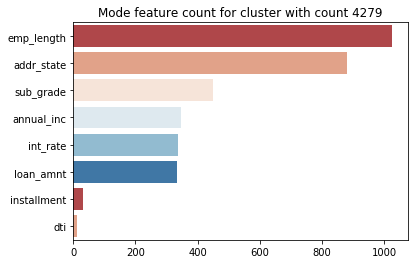

              Column |     Mode | Mode Count | Mean
------------------------------------------------------------------
           loan_amnt |  12000.0 |       310 | 15348.297021511307
                term |      0.0 |      2154 | 0.4059569773855488
            int_rate |    11.71 |       212 | 12.73715940430188
         installment |   307.04 |        22 | 426.41574738003175
               grade |      1.0 |      1090 | 1.6249310535024821
           sub_grade |      7.0 |       288 | 10.065912851627138
          emp_length |      1.0 |      1141 | 3.636238279095422
      home_ownership |      0.0 |      2035 | 0.8243243243243243
          annual_inc |  65000.0 |       251 | 80659.7797931605
 verification_status |      2.0 |      1690 | 1.1971869829012687
             purpose |      2.0 |      1958 | 3.203530060672918
          addr_state |      4.0 |       674 | 19.052399338113624
                 dti |    10.45 |         7 | 13.74099282956427
         delinq_2yrs |      0.0 |      325

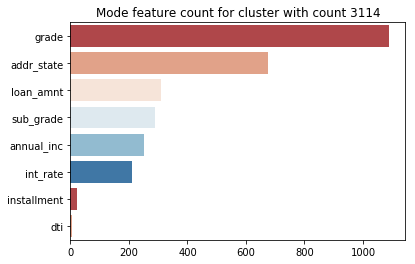

              Column |     Mode | Mode Count | Mean
------------------------------------------------------------------
           loan_amnt |  35000.0 |       140 | 19115.251423149904
                term |      0.0 |       631 | 0.40132827324478176
            int_rate |      7.9 |        59 | 13.043510436432598
         installment |  1111.37 |         9 | 537.4373529411761
               grade |      1.0 |       304 | 1.7552182163187855
           sub_grade |      3.0 |        81 | 10.734345351043643
          emp_length |      1.0 |       347 | 3.6394686907020875
      home_ownership |      0.0 |       740 | 0.5559772296015181
          annual_inc | 120000.0 |       138 | 144498.7320398482
 verification_status |      2.0 |       592 | 1.4478178368121442
             purpose |      2.0 |       503 | 3.462998102466793
          addr_state |      4.0 |       234 | 18.61764705882353
                 dti |     9.94 |         5 | 11.40123339658444
         delinq_2yrs |      0.0 |       

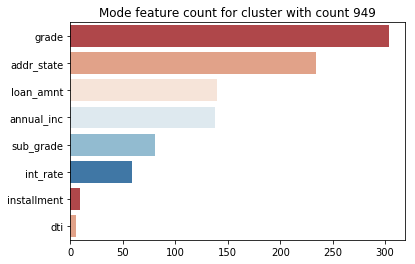

In [20]:
for cluster in clusters:
    cluster = print_mode(cluster)
    display_cluster_mode_feature(cluster)

## Preparing the dataset 

Normalize the data set for ease of calculations so that all features have values between 0 and 1.

In [21]:
df=(df-df.min())/(df.max()-df.min())

Randomize the dataset so that any ordered patterns dont influence the prediction. (We have already skipped date as an influencing factor)

In [22]:
df = df.iloc[np.random.permutation(len(df))]

The data is split into training and testing data. x represents the input features whereas y represents the output i.e. the interest rate.As a rule of thumb, we split the data into 80% training data and 20% testing or validation data.

In [23]:
y = df.iloc[:,df.columns.isin(["int_rate"])]
x = df.loc[:, ~df.columns.isin(["int_rate"])]

total_samples=len(df)
split = 0.8

x_train = x[0:int(total_samples*split)]
x_test = x[int(total_samples*split):total_samples]
y_train = y[0:int(total_samples*split)]
y_test = y[int(total_samples*split):total_samples]

In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    Calculates mean absolute error of the true and predicted values.
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    count = 0
    sum = 0
    for a, p in zip(y_true, y_pred):
        if(a!=0):
            sum+=(abs(a-p)/a)
            count+=1
    return (sum/count) * 100

In [25]:
def view_metrics(y_test, predictions, algorithm, samples, total_samples):
    '''
    Plots the true and predicted values and prints RMS, MAE and MAPE metrics.
    '''
    fig = plt.figure(figsize=(18,5))
    plt.scatter(x=[i for i in range(samples)], y=[x for x in predictions[0:samples]], label='Predicted values')
    plt.scatter(x=[i for i in range(samples)], y=[x[0] for x in y_test.values[0:samples]], label='True values')
    plt.title('True and Predicted values for test dataset - %s' % algorithm)
    plt.legend()
    plt.show()
    
    fig = plt.figure(figsize=(18,5))
    plt.scatter(x=[i for i in range(total_samples)], y=[x for x in predictions], label='Predicted values')
    plt.scatter(x=[i for i in range(total_samples)], y=[x[0] for x in y_test.values], label='True values')
    plt.title('True and Predicted values for test dataset - %s' % algorithm)
    plt.legend()
    plt.show()

    RMS =  np.sqrt(mean_squared_error(y_test, predictions, multioutput='raw_values'))
    MAE = mean_absolute_error(y_test, predictions, multioutput='raw_values')
    MAPE = mean_absolute_percentage_error(y_test, predictions)
    print("Root Mean Squared Error:", RMS)
    print("Mean Absolute Error", MAE) 
    print("Mean Absolute Percentage Error", MAPE)
    return RMS, MAE, MAPE

### Metrics for regression models

#### Root Mean Squared Error
It represents the sample standard deviation of the differences between predicted values and observed values.

![alt text](rmse.PNG "RMSE")

#### Mean Absolute Error
MAE is the average of the absolute difference between the predicted values and observed value. The MAE is a linear score which means that all the individual differences are weighted equally in the average.

![alt text](mae.PNG "MAE")

#### Mean Absolute Percent Error
MAPE measures the size of the error in percentage terms. It is calculated as the average of the unsigned percentage error.

![alt text](mape.PNG "MAPE")

### Linear Regression Model

In [26]:
lin_reg_model = LinearRegression() # build model
lin_reg_model= lin_reg_model.fit(x_train, y_train) # train model
R2 = lin_reg_model.score(x_train, y_train) # coefficient of determination

In [27]:
lin_reg_model_predictions = lin_reg_model.predict(x_test) # make predictions

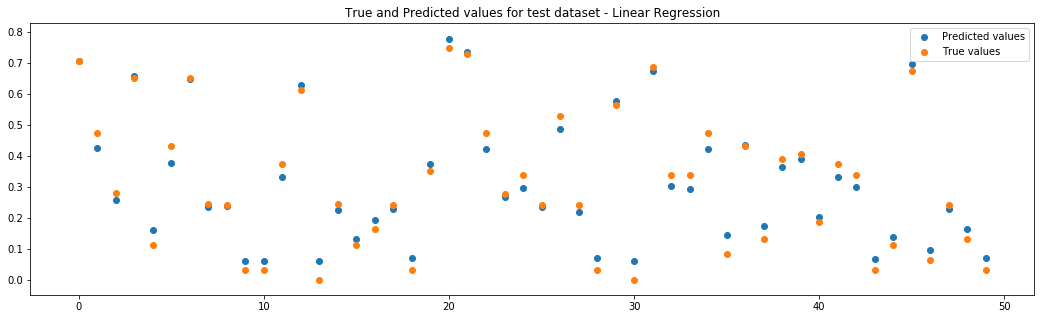

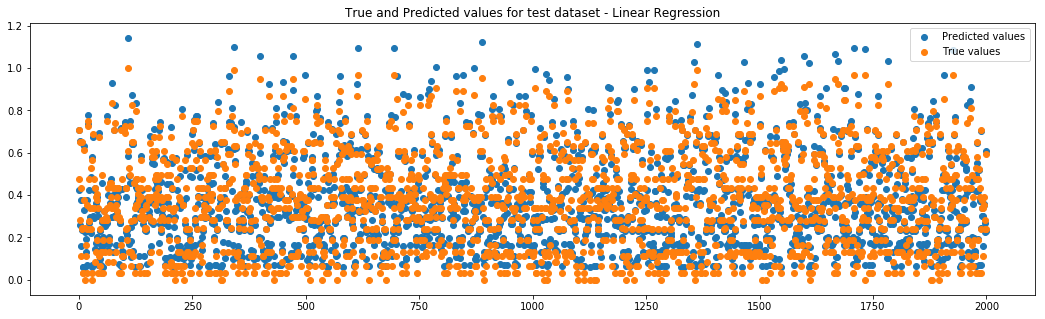

Root Mean Squared Error: [0.03795809]
Mean Absolute Error [0.03115924]
Mean Absolute Percentage Error [19.33082824]


In [28]:
lin_reg_model_metrics = view_metrics(y_test, lin_reg_model_predictions,'Linear Regression', samples = 50, total_samples=2000)
## If predicted value is same as true value, the points will be overlapping. Closer the points, better is the prediction.

### Random Forest Regressor Model

In [29]:
rand_forest_model = RandomForestRegressor(max_depth=5, random_state=0) # build model
rand_forest_model = rand_forest_model.fit(x_train, y_train.values.ravel()) # train model
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
feature_importance = rand_forest_model.feature_importances_
R2 = rand_forest_model.score(x_train, y_train) # coefficient of determination
rand_forest_model_predictions = rand_forest_model.predict(x_test) # make predictions

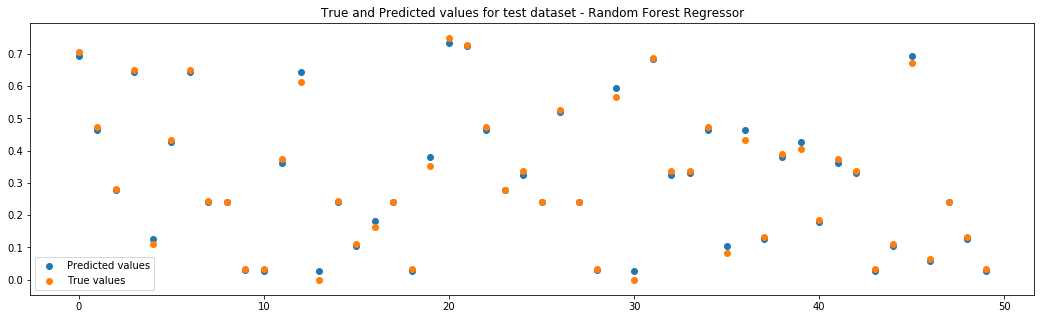

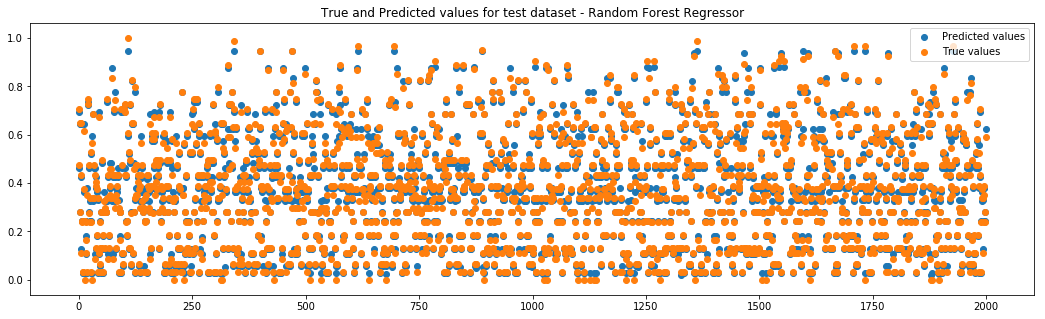

Root Mean Squared Error: [0.01694133]
Mean Absolute Error [0.01180371]
Mean Absolute Percentage Error [6.07508803]


In [30]:
rand_forest_model_metrics = view_metrics(y_test, rand_forest_model_predictions,'Random Forest Regressor', samples = 50, total_samples=2000)

### Neural Network Regression Model

In [31]:
nn_model = MLPRegressor(hidden_layer_sizes=(10,4),
                                    activation='relu', # activation function in the nodes of the neral net
                                    solver='adam', # optimizer algorithm
                                    learning_rate='constant',
                                    learning_rate_init=0.001, # initial learning rate
                                    max_iter=300, # max iterations to train for
                                    tol = -1, # tolerance for when to stop training should be range 0.001 to 0.0000001, -1 for max_iter
                                    shuffle=True,
                                    verbose=True) # show details at each iteration
nn_model = nn_model.fit(x_train, y_train.values.ravel())

Iteration 1, loss = 0.13710534
Iteration 2, loss = 0.04697399
Iteration 3, loss = 0.02773502
Iteration 4, loss = 0.01892204
Iteration 5, loss = 0.01342491
Iteration 6, loss = 0.00908341
Iteration 7, loss = 0.00565302
Iteration 8, loss = 0.00327734
Iteration 9, loss = 0.00194878
Iteration 10, loss = 0.00143035
Iteration 11, loss = 0.00120003
Iteration 12, loss = 0.00105150
Iteration 13, loss = 0.00094479
Iteration 14, loss = 0.00085955
Iteration 15, loss = 0.00078672
Iteration 16, loss = 0.00072359
Iteration 17, loss = 0.00066763
Iteration 18, loss = 0.00061663
Iteration 19, loss = 0.00057085
Iteration 20, loss = 0.00052686
Iteration 21, loss = 0.00048795
Iteration 22, loss = 0.00045288
Iteration 23, loss = 0.00041936
Iteration 24, loss = 0.00038957
Iteration 25, loss = 0.00036088
Iteration 26, loss = 0.00033443
Iteration 27, loss = 0.00031420
Iteration 28, loss = 0.00029459
Iteration 29, loss = 0.00027756
Iteration 30, loss = 0.00026229
Iteration 31, loss = 0.00024974
Iteration 32, los

Iteration 253, loss = 0.00013625
Iteration 254, loss = 0.00013626
Iteration 255, loss = 0.00013247
Iteration 256, loss = 0.00013349
Iteration 257, loss = 0.00013613
Iteration 258, loss = 0.00013127
Iteration 259, loss = 0.00013100
Iteration 260, loss = 0.00013390
Iteration 261, loss = 0.00013299
Iteration 262, loss = 0.00013414
Iteration 263, loss = 0.00013504
Iteration 264, loss = 0.00013100
Iteration 265, loss = 0.00013224
Iteration 266, loss = 0.00013299
Iteration 267, loss = 0.00013140
Iteration 268, loss = 0.00013199
Iteration 269, loss = 0.00013466
Iteration 270, loss = 0.00013295
Iteration 271, loss = 0.00013116
Iteration 272, loss = 0.00012990
Iteration 273, loss = 0.00013280
Iteration 274, loss = 0.00013134
Iteration 275, loss = 0.00013143
Iteration 276, loss = 0.00013242
Iteration 277, loss = 0.00013065
Iteration 278, loss = 0.00013193
Iteration 279, loss = 0.00013150
Iteration 280, loss = 0.00013193
Iteration 281, loss = 0.00012968
Iteration 282, loss = 0.00012985
Iteration 

c:\users\atharva jakkanwar\anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [32]:
nn_model_predictions = nn_model.predict(x_test)

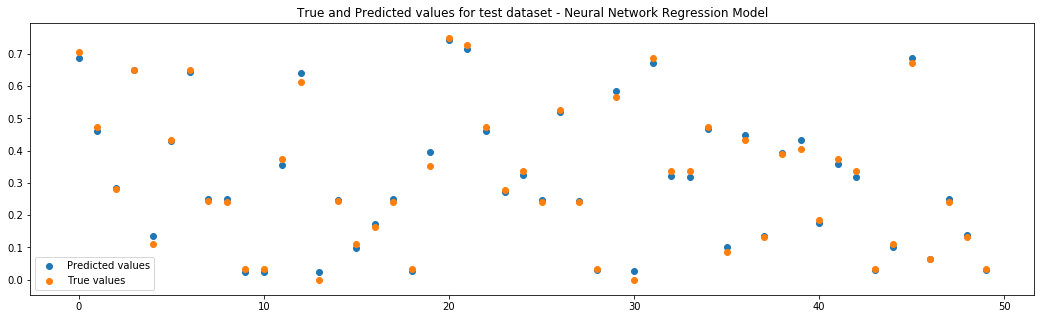

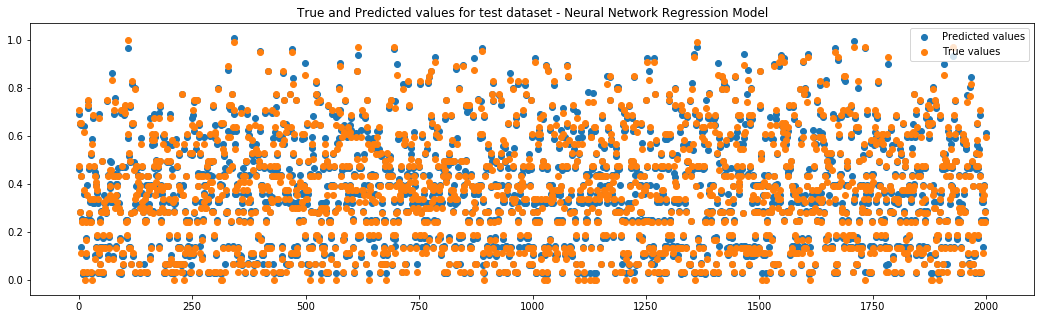

Root Mean Squared Error: [0.01827546]
Mean Absolute Error [0.01309697]
Mean Absolute Percentage Error [6.56480156]


In [33]:
nn_model_metrics = view_metrics(y_test, nn_model_predictions,'Neural Network Regression Model', samples = 50, total_samples=2000)

## Comparing model performances

In [34]:
print("%10s | %7s | %7s | %7s" % ('MODEL', 'RMSE', 'MAE', 'MAPE'))
print('___________________________________________')
for name,metrics in zip(['LIN_REG','RAND_FRST','NN'],[lin_reg_model_metrics, rand_forest_model_metrics, nn_model_metrics]):
    print ("%10s | %.5f | %.5f | %.5f %%" % (name, metrics[0][0], metrics[1][0], metrics[2][0]))
print()
print('Note: Lower values are better')

     MODEL |    RMSE |     MAE |    MAPE
___________________________________________
   LIN_REG | 0.03796 | 0.03116 | 19.33083 %
 RAND_FRST | 0.01694 | 0.01180 | 6.07509 %
        NN | 0.01828 | 0.01310 | 6.56480 %

Note: Lower values are better


## Predicting interest rates

In [35]:
def get_interest_rate(model, features):
    return (model.predict(features))*(max_rate-min_rate) + min_rate

In [36]:
sample = x_test[2:3] # substitute with the input you want to predict the rate for
interest_rate = get_interest_rate(rand_forest_model, sample)
print('Predicted interest rate is:', interest_rate)
print('for the following user profile:')
sample

Predicted interest rate is: [10.63925742]
for the following user profile:


,loan_amnt,term,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,loan_status_Binary
5126,0.470588,1.0,0.272092,0.166667,0.176471,0.909091,0.0,0.043289,0.5,0.25,0.090909,0.365642,0.0,0.0,0.0


### Saving the models

In [37]:
# this cell may take a few seconds to execute depending on model size

# for saving models
import pickle
# import _pickle as cPickle # try this if previous import fails

model_name = 'best_model.model'
pickle.dump(rand_forest_model, open(model_name, 'wb'))